In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial

In [2]:
df = pd.read_csv('data/train_data/train_task_3_4.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382727 entries, 0 to 1382726
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   QuestionId     1382727 non-null  int64
 1   UserId         1382727 non-null  int64
 2   AnswerId       1382727 non-null  int64
 3   IsCorrect      1382727 non-null  int64
 4   CorrectAnswer  1382727 non-null  int64
 5   AnswerValue    1382727 non-null  int64
dtypes: int64(6)
memory usage: 63.3 MB


<Axes: >

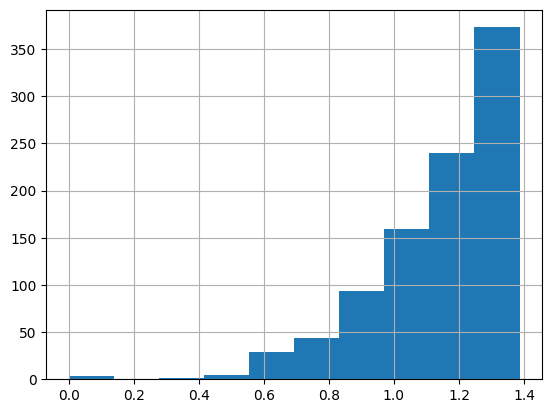

In [3]:
answerEntropy = df.groupby('QuestionId')['AnswerValue'].apply(lambda x:multinomial.entropy(1, x.value_counts(normalize=True)))
answerEntropy.hist()

<Axes: >

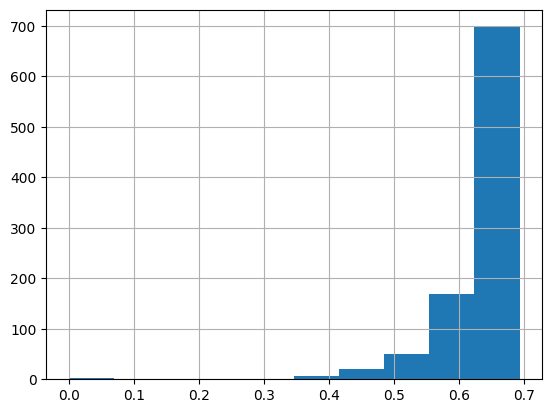

In [4]:
correctEntropy = df.groupby('QuestionId')['IsCorrect'].apply(lambda x:multinomial.entropy(1, x.value_counts(normalize=True)))
correctEntropy.hist()

In [5]:
metadata = pd.read_csv('data/metadata/answer_metadata_task_3_4.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508917 entries, 0 to 1508916
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   AnswerId        1508917 non-null  int64  
 1   DateAnswered    1508917 non-null  object 
 2   Confidence      383096 non-null   float64
 3   GroupId         1508917 non-null  int64  
 4   QuizId          1508917 non-null  int64  
 5   SchemeOfWorkId  1365456 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 69.1+ MB


In [6]:
df = pd.merge(left=df,right=metadata,how='inner',on='AnswerId')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382727 entries, 0 to 1382726
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   QuestionId      1382727 non-null  int64  
 1   UserId          1382727 non-null  int64  
 2   AnswerId        1382727 non-null  int64  
 3   IsCorrect       1382727 non-null  int64  
 4   CorrectAnswer   1382727 non-null  int64  
 5   AnswerValue     1382727 non-null  int64  
 6   DateAnswered    1382727 non-null  object 
 7   Confidence      346428 non-null   float64
 8   GroupId         1382727 non-null  int64  
 9   QuizId          1382727 non-null  int64  
 10  SchemeOfWorkId  1267192 non-null  float64
dtypes: float64(2), int64(8), object(1)
memory usage: 116.0+ MB


In [7]:
df['Confidence'] = df['Confidence'].fillna(50)

<Axes: >

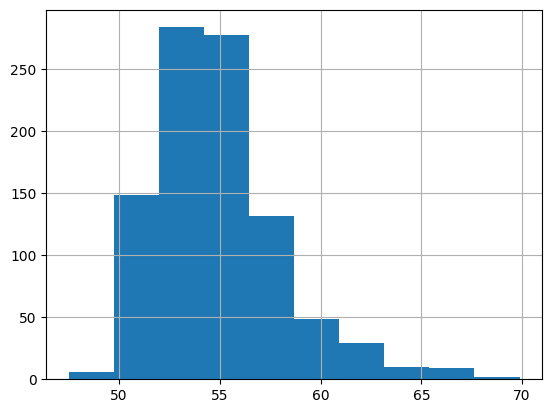

In [8]:
cf = df.groupby('QuestionId')['Confidence'].agg('mean')
cf.hist()

In [9]:
studentmeta = pd.read_csv('data/metadata/student_metadata_task_3_4.csv')
studentmeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6148 entries, 0 to 6147
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   UserId        6148 non-null   int64  
 1   Gender        6148 non-null   int64  
 2   DateOfBirth   2834 non-null   object 
 3   PremiumPupil  2541 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 192.2+ KB


In [10]:
df = pd.merge(left=df,right=studentmeta,how='inner',on='UserId')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382727 entries, 0 to 1382726
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   QuestionId      1382727 non-null  int64  
 1   UserId          1382727 non-null  int64  
 2   AnswerId        1382727 non-null  int64  
 3   IsCorrect       1382727 non-null  int64  
 4   CorrectAnswer   1382727 non-null  int64  
 5   AnswerValue     1382727 non-null  int64  
 6   DateAnswered    1382727 non-null  object 
 7   Confidence      1382727 non-null  float64
 8   GroupId         1382727 non-null  int64  
 9   QuizId          1382727 non-null  int64  
 10  SchemeOfWorkId  1267192 non-null  float64
 11  Gender          1382727 non-null  int64  
 12  DateOfBirth     727345 non-null   object 
 13  PremiumPupil    707860 non-null   float64
dtypes: float64(3), int64(9), object(2)
memory usage: 147.7+ MB


In [11]:
df['DateOfBirth'] = df['DateOfBirth'].fillna("2222")
df['DateOfBirth'].max()

'2222'

In [12]:
df['DateAnswered'] = df['DateAnswered'].apply(lambda x: int(x[:4]))

In [13]:
df['DateOfBirth'] = df['DateOfBirth'].apply(lambda x: int(x[:4]))
df['DateOfBirth'].max()

2222

In [14]:
df['Age'] = df['DateAnswered'] - df['DateOfBirth']
df['Age'] = df['Age'].apply(lambda x: 0 if x<= 0 else x)

<Axes: >

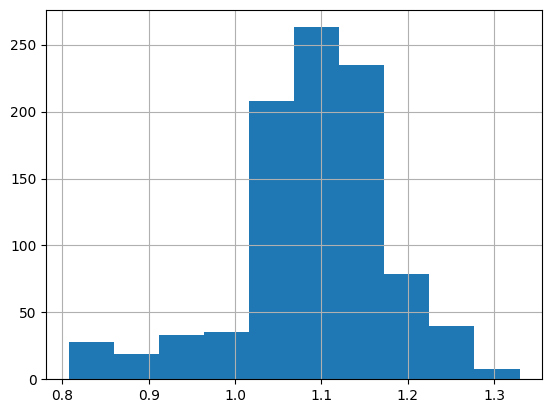

In [15]:
ageEntropy = df.groupby('QuestionId')['Age'].apply(lambda x:multinomial.entropy(1, x.value_counts(normalize=True)))
ageEntropy.hist()

In [16]:
def get_ranking(series,ascending=False):
    return series.rank(method='first',ascending=ascending).astype('int16')
def get_ranking2(series,ascending=True):
    return series.rank(method='first',ascending=ascending).astype('int16')

In [17]:
template = pd.read_csv('submission/template.csv')
ranking_df = pd.DataFrame()
ranking_df['SelectionEntropy'] = get_ranking(answerEntropy)
ranking_df['CorrectnessEntropy'] = get_ranking(correctEntropy)
ranking_df['Confidence'] = get_ranking(cf)
ranking_df['Age'] = get_ranking2(ageEntropy)
df_columns = ranking_df.columns.copy()
ranking_df['1+2'] = get_ranking(
    ranking_df[df_columns[:2]].mean(axis='columns'), ascending=True
)
ranking_df['1+2+3'] = get_ranking(
    ranking_df[df_columns[:3]].mean(axis='columns'), ascending=True
)
ranking_df['1+2+3+4'] = get_ranking(
    ranking_df[df_columns[:4]].mean(axis='columns'), ascending=True
)
ranking_df

,SelectionEntropy,CorrectnessEntropy,Confidence,Age,1+2,1+2+3,1+2+3+4
QuestionId,,,,,,,
0,484,247,299,746,391,133,383
1,844,293,897,454,672,906,865
2,124,481,520,657,230,204,391
3,908,915,82,644,919,860,878
4,150,405,831,80,160,458,152
...,...,...,...,...,...,...,...
943,780,274,41,581,636,185,291
944,188,938,603,8,669,753,351
945,331,324,297,643,296,90,229


In [18]:
def write_file(ranking):
    submission_df = pd.read_csv('submission/template.csv')
    submission_df['ranking'] = ranking
    submission_df.to_csv('submission/template.csv', index=False)

In [19]:
# load evaluators' score on "validation" set
eval_validation = pd.read_csv('data/test_data/quality_response_remapped_public.csv')
print(len(eval_validation))
eval_validation.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,0,0,909,318,2,2,2,1.0,2
1,16,16,285,609,2,2,2,2.0,2
2,48,48,132,271,1,2,2,2.0,1
3,38,38,704,127,2,2,1,2.0,2
4,33,33,16,586,1,1,2,2.0,2


In [20]:
eval_validation['score'] = eval_validation.filter(regex='^T', axis = 1).mean(axis=1)


<Axes: >

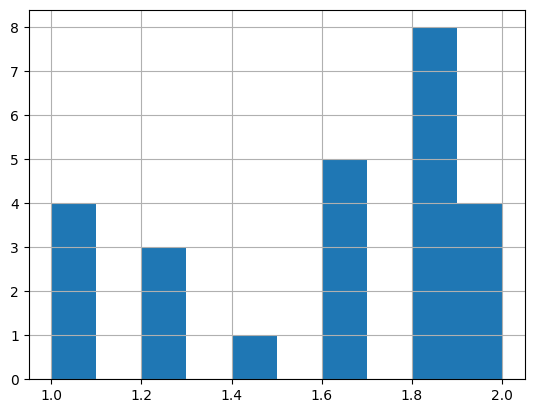

In [21]:
def calc_preference(scores):
    preference = np.ones(len(scores), dtype=int)

    idx_two = scores > 1.5
    preference[idx_two] = 2
    
    return list(preference)

eval_validation['preference'] = calc_preference(eval_validation['score'])
# eval_dev[]
# eval_dev['score']
eval_validation['score'].hist()

25


<Axes: >

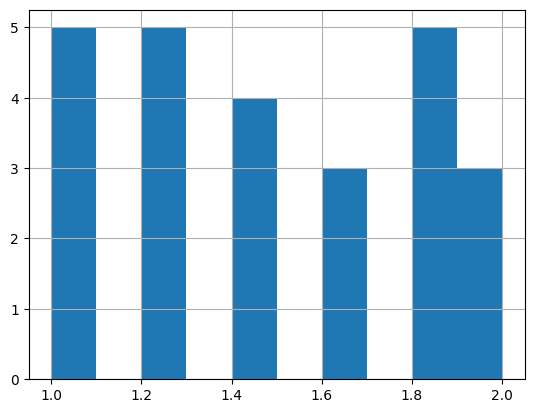

In [22]:
eval_test = pd.read_csv('data/test_data/quality_response_remapped_private.csv')
print(len(eval_test))
eval_test.head()
# take the average of scores by 5 evaulators
eval_test['score'] = eval_test.filter(regex='^T', axis = 1).mean(axis=1)
eval_test['score'].hist()

In [23]:
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    return(submission_preference)

In [24]:
ALR = eval_validation['T1_ALR'].tolist()
CL = eval_validation['T2_CL'].tolist()
GF = eval_validation['T3_GF'].tolist()
MQ = eval_validation['T4_MQ'].tolist()
NS = eval_validation['T5_NS'].tolist()
ALL = eval_validation['preference'].tolist()

In [25]:
def getScore(A,B):
    same = 0
    for idx in range(len(A)):
        if A[idx] == B[idx]:
            same = same + 1
    return same/len(A)

In [26]:
ranking_df_columns = ranking_df.columns
result_df = pd.DataFrame()

In [27]:
def result(f,input_data):
    write_file(ranking_df[f])
    template = pd.read_csv('submission/template.csv')
    a = evaluate(input_data, template)
    alr = getScore(a,ALR)
    cl = getScore(a,CL)
    gf = getScore(a,GF)
    mq = getScore(a,MQ)
    ns = getScore(a,NS)
    al = getScore(a,ALL)
    dic = {'ALR': alr,'CL':cl,'GF':gf,'MQ':mq,'NS':ns,'ALL':al}
    result_df[f] = dic

In [28]:
for i in ranking_df_columns:
    result(i,eval_validation)
result_df

,SelectionEntropy,CorrectnessEntropy,Confidence,Age,1+2,1+2+3,1+2+3+4
ALR,0.72,0.72,0.28,0.44,0.68,0.76,0.64
CL,0.76,0.84,0.40,0.32,0.80,0.80,0.76
GF,0.76,0.68,0.24,0.56,0.72,0.64,0.60
MQ,0.64,0.56,0.28,0.44,0.60,0.52,0.48
NS,0.64,0.64,0.36,0.36,0.60,0.60,0.56
ALL,0.84,0.76,0.24,0.48,0.80,0.72,0.68


In [29]:
for i in ranking_df_columns:
    result(i,eval_test)
result_df

,SelectionEntropy,CorrectnessEntropy,Confidence,Age,1+2,1+2+3,1+2+3+4
ALR,0.44,0.44,0.52,0.76,0.36,0.48,0.48
CL,0.40,0.48,0.56,0.64,0.40,0.44,0.52
GF,0.40,0.40,0.64,0.72,0.32,0.44,0.60
MQ,0.28,0.44,0.60,0.60,0.44,0.40,0.48
NS,0.52,0.36,0.52,0.76,0.36,0.40,0.56
ALL,0.32,0.40,0.56,0.80,0.32,0.36,0.52
